# Predição do Modelo

In [143]:
import boto3
import pandas as pd
import numpy as np
from sagemaker.session import Session
from sagemaker.s3 import S3Uploader

In [259]:
# ENCONTRANDO O JOB DE TREINAMENTO
sagemaker_client = boto3.client("sagemaker")

subpasta_modelo: str = f'modelos/xgboost/output'
subpasta_dataset: str = f'datasets'

response = sagemaker_client.list_training_jobs(SortBy="CreationTime", SortOrder="Descending", MaxResults=1)

if "TrainingJobSummaries" in response:
    last_training_job_name = response["TrainingJobSummaries"][0]["TrainingJobName"]
    print(f"Último job de treinamento: {last_training_job_name}")
else:
    print("Nenhum job de treinamento encontrado.")

s3_model_data: str = f"{subpasta_modelo}/{last_training_job_name}/output/model.tar.gz"
s3_test_data: str = f"{subpasta_dataset}/test/hotel_reservations_test_xgboost"

zipped_model: str = "model.tar.gz"
test_dataset: str = "test-data-xgboost.csv"
model_file: str = "xgboost-model"

Último job de treinamento: sagemaker-xgboost-2024-07-15-09-42-00-093


In [260]:
# DOWNLOAD DO MODELO DO S3

bucket_name = 'hotel-reservations-ml'

s3_client = boto3.client('s3')

s3_client.download_file(bucket_name, s3_model_data, zipped_model)
s3_client.download_file(bucket_name, s3_test_data, test_dataset)

df_teste = pd.read_csv(test_dataset)

print(df_teste)

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [ ]:
X_test = df_teste.iloc[:, 1:23].values
y_test = df_teste.iloc[:, 0].values

In [ ]:
with tarfile.open(zipped_model, 'r:gz') as tar:
    tar_list = tar.getnames()
    print("Files in the tar archive:", tar_list)
    tar.extractall()


In [ ]:
import xgboost as xgb

model = xgb.Booster()
model.load_model(model_file)

In [261]:
dtest = xgb.DMatrix(X_test)

predictions = model.predict(dtest)

predictions

array([1., 1., 2., ..., 1., 1., 0.], dtype=float32)

[1 1 2 ... 1 1 0]
Accuracy:  0.6466642161367395
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      3358
           1       0.58      0.70      0.64      4211
           2       0.73      0.61      0.67      3313

    accuracy                           0.65     10882
   macro avg       0.66      0.64      0.65     10882
weighted avg       0.66      0.65      0.65     10882



Text(0.5, 1.0, 'Confusion Matrix')

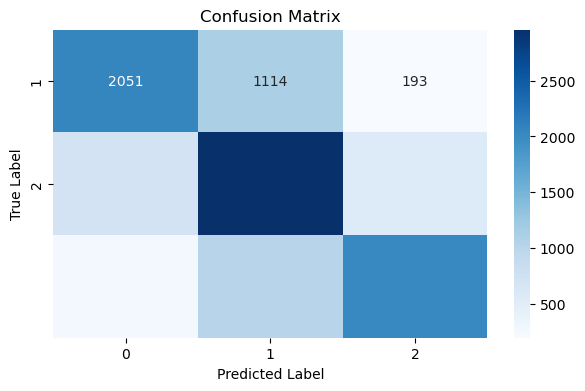

In [262]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

round_predictions = np.round(predictions).astype(int)
print(round_predictions)

print("Accuracy: ", accuracy_score(y_test, round_predictions))

print(classification_report(y_test, round_predictions))

conf_matrix = confusion_matrix(y_test, round_predictions)

plt.figure(figsize=(7, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[0, 1, 2],
    yticklabels=[1, 2],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#plt.show()